#### [00] Importing packages
Import several packages that would be used for acquiring sample data.

In [1]:
import pandas as pd 
import numpy as np
import os
import scipy

import warnings
warnings.filterwarnings("ignore")

import modin.pandas as mpd
os.environ["MODIN_ENGINE"] = "dask"

import warnings
warnings.filterwarnings("ignore")

from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.stats import chi2

from google.cloud import storage
import gcsfs

import glob

%matplotlib inline
from ipywidgets import interact, fixed
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from omegaconf import DictConfig,OmegaConf

sns.set(rc = {'figure.figsize':(15,10)})

**!! Edit kdPIC parameter**

specify the "kdPIC" and the band that would be calculated

In [2]:
conf = OmegaConf.load('config/config.yaml')
pic_=conf['config']['pic_']
data_sample=mpd.read_csv("gs://bps-gcp-bucket/MLST2023/sample/sample_"+str(pic_) + ".csv",sep=',')
# data_sample = data_sample.iloc[0:100,:]


data_sample['nama_valid']=data_sample.nama_valid.apply(lambda y: str(y)[:6])
data_sample.head()

distributed.diskutils - INFO - Found stale lock file and directory '/home/jupyter-peta_admin/dask-worker-space/worker-mqn2cj9c', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jupyter-peta_admin/dask-worker-space/worker-isul4j6m', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jupyter-peta_admin/dask-worker-space/worker-ekwnxqku', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jupyter-peta_admin/dask-worker-space/worker-lr562_0h', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jupyter-peta_admin/dask-worker-space/worker-bch0vmhg', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jupyter-peta_admin/dask-worker-space/worker-p88i22b0', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jupyter-peta_admin/dask-worker-space/worker-ht_87spn', purging
distributed.diskutils - INFO - Found stal

,ID_GRID,sub_grid,kdPIC,nama_valid,B1_p15,B2_p15,B3_p15,B4_p15,B5_p15,B6_p15,...,B11_p15,B12_p15,NDVI_p50,NDWI_p50,NDBI_p50,SAVI_p50,EVI_p50,GNDVI_p50,cen_x,cen_y
0,ID-3551,ID-3551_3,F,100205,0.125467,0.111364,0.100140,0.081880,0.094037,0.160095,...,0.138287,0.089802,0.311113,-0.255941,-0.033498,0.145286,0.285223,0.255941,116.236155,-8.535342
1,ID-3551,ID-3551_3,F,100108,0.110925,0.080687,0.069318,0.038510,0.065533,0.200976,...,0.116098,0.042238,0.735738,-0.583992,-0.370043,0.378651,0.701286,0.583992,116.240472,-8.535888
2,ID-3551,ID-3551_3,F,100108,0.113750,0.080855,0.066904,0.036998,0.062777,0.188153,...,0.109560,0.039364,0.740340,-0.594169,-0.390957,0.380327,0.700704,0.594169,116.240292,-8.536069
3,ID-3551,ID-3551_3,F,100108,0.110800,0.080607,0.068308,0.037966,0.065234,0.210288,...,0.118610,0.043371,0.744049,-0.599870,-0.380511,0.396373,0.727959,0.599870,116.240472,-8.536069
4,ID-3551,ID-3551_3,F,100108,0.113300,0.081206,0.068857,0.039403,0.064607,0.192827,...,0.116713,0.043028,0.719150,-0.578370,-0.357034,0.368722,0.684427,0.578370,116.239573,-8.537524


#### [01] Check Completeness

In [3]:
def check_complete(df):
    u=1
    for i in df.columns:
        if (df[[i]].isnull().values.any()):
            print('Columns',i,' is nan ')
            u=2
    if u>1:
        print('Rows with NAN-valued detected. Those will be truncated.')
    else:
        print('No Rows with NAN-valued detected')
    
    return df.dropna()

def check_columns_existed(df):
    standard_=['ID_GRID','kdPIC','nama_valid','B1_p15','B2_p15','B3_p15','B4_p15','B5_p15','B6_p15','B7_p15',
          'B8_p15','B8A_p15','B11_p15','B12_p15','NDVI_p50','NDWI_p50','NDBI_p50','SAVI_p50',
          'EVI_p50','GNDVI_p50','cen_x','cen_y']
    coln_=df.columns
    
    l_st_not_in_col=[i for i in standard_ if(i not in coln_)]
    
    l_col_not_in_st=[i for i in df.columns if(i not in standard_)]
    if len(l_col_not_in_st)>0:
        print('Columns in dataframe not in standard:',end=' ')
        for i in l_col_not_in_st:
            print(i, end=',')
            df.drop(i,inplace=True,axis=1)
        print('\nThe columns above would be truncated')
        
    if len(l_st_not_in_col)>0:
        print('Columns in standard columns not in dataframe:',end=' ')
        for i in l_st_not_in_col:
            print(i, end=',')
        raise ValueError("Columns not standard")
        
    print('All Columns in data has been standardized')
    return df  

def check_category(df):
    if 'nama_valid' in df.columns:
        y_=df.nama_valid.unique()
        standard_=['100101','100102','100103','100104','100105','100106','100107','100108',
                  '100201','100202','100203','100204','100205','100206','100301','100302']
        y_a=[i for i in y_ if i not in standard_]
        y_b=[i for i in standard_ if i not in y_ ]
        
        if len(y_b)>0:
            print('Following land cover categories are not found in the data:', y_b)
        if len(y_a)>0:
            print('Following land cover categories are not match with standard:',y_a)
            print('Please correct them first!')
            # raise ValueError('Please correct them first',y_a)
    else:
        raise ValueError('The "nama_valid" column is not detected. Please correct the data first!')

def remove_all_rows_zero_Value(df):
    print('Remove All Rows, which have zero value in all band columns and indices columns')
    standard_=['B1_p15','B2_p15','B3_p15','B4_p15','B5_p15','B6_p15','B7_p15',
          'B8_p15','B8A_p15','B11_p15','B12_p15','NDVI_p50','NDWI_p50','NDBI_p50','SAVI_p50',
          'EVI_p50','GNDVI_p50']
    df = df[~(df[standard_] == 0).all(axis=1)]
    return df

In [4]:
data_sample=check_complete(data_sample)
data_sample=check_columns_existed(data_sample)
standard_class=['100101','100102','100103','100104','100105','100106','100107','100108',
                  '100201','100202','100203','100204','100205','100206','100301','100302']
data_sample=data_sample.query('nama_valid in @standard_class').sort_values('nama_valid')
check_category(data_sample)
data_sample=remove_all_rows_zero_Value(data_sample)
data_sample.head(5)

No Rows with NAN-valued detected
Columns in dataframe not in standard: sub_grid,
The columns above would be truncated
All Columns in data has been standardized
Following land cover categories are not found in the data: ['100103', '100104', '100105', '100106']
Remove All Rows, which have zero value in all band columns and indices columns


,ID_GRID,kdPIC,nama_valid,B1_p15,B2_p15,B3_p15,B4_p15,B5_p15,B6_p15,B7_p15,...,B11_p15,B12_p15,NDVI_p50,NDWI_p50,NDBI_p50,SAVI_p50,EVI_p50,GNDVI_p50,cen_x,cen_y
40633,ID-3552,F,100101,0.123700,0.094636,0.089939,0.059908,0.084963,0.135388,0.160281,...,0.124797,0.062274,0.346570,-0.326001,0.043190,0.171850,0.293667,0.326001,116.286877,-8.787510
34794,ID-3087,F,100101,0.113775,0.087165,0.077134,0.046095,0.071875,0.148042,0.177015,...,0.114919,0.048215,0.529673,-0.445925,-0.250871,0.265705,0.465287,0.445925,114.715942,-8.376958
69567,ID-3602,F,100101,0.124200,0.090467,0.083450,0.051760,0.089700,0.201733,0.248600,...,0.125200,0.052333,0.565998,-0.454280,-0.236746,0.287592,0.545542,0.454280,116.429150,-8.738555
69566,ID-3602,F,100101,0.119300,0.094706,0.086550,0.057895,0.084850,0.168189,0.208526,...,0.136575,0.060970,0.473970,-0.388314,-0.178973,0.222110,0.404131,0.388314,116.460986,-8.738373
69565,ID-3602,F,100101,0.124275,0.094216,0.085971,0.057893,0.089135,0.168869,0.209434,...,0.127778,0.062385,0.516613,-0.413534,-0.180182,0.239402,0.438249,0.413534,116.460806,-8.738373


#### [02] Data Summarization

Count data by category
            Count Data
nama_valid            
100101           38479
100102            7157
100107            3791
100108            8690
100201            1971
100202             621
100203            1207
100204             480
100205           17126
100206             415
100301             195
100302             440


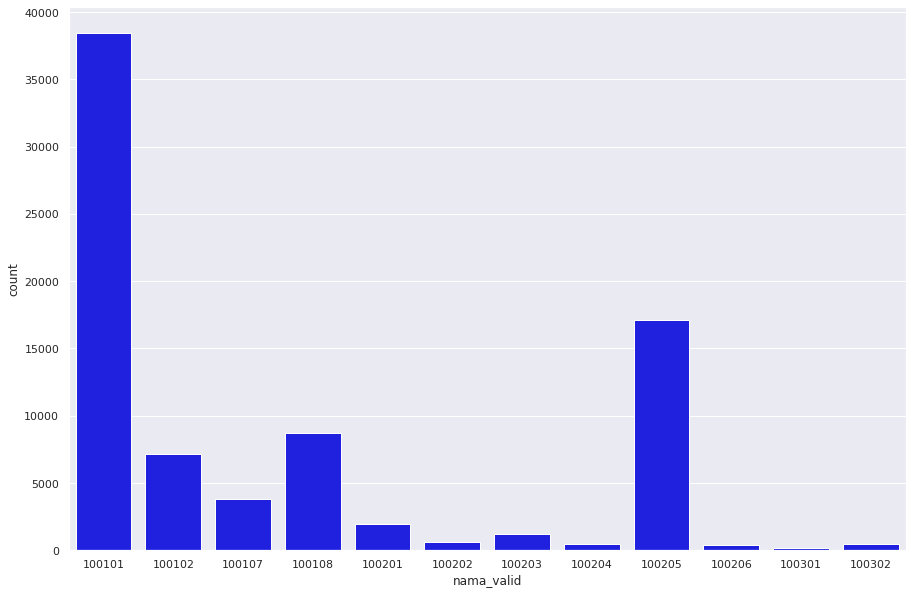

In [5]:
print('Count data by category')
data_sample.pivot_table(index='nama_valid',values='ID_GRID',
                              aggfunc='count').rename(columns={'ID_GRID':'Count Data'})
print(data_sample.pivot_table(index='nama_valid',values='ID_GRID',
                              aggfunc='count').rename(columns={'ID_GRID':'Count Data'}))
sns.countplot(x='nama_valid',data=data_sample._to_pandas(),color='blue')
plt.show()


In [32]:
print('\nCount data by id_grid')
print(data_sample.pivot_table(index='ID_GRID',values='nama_valid',
                              aggfunc='count').rename(columns={'nama_valid':'Count Data'})
      .sort_values(by='Count Data',ascending=False)
)
print('\nData Description')
print(data_sample.describe())


Count data by id_grid
         Count Data
ID_GRID            
ID-3602        7515
ID-3225        7160
ID-3552        5328
ID-3497        4703
ID-3601        3500
...             ...
ID-4734           2
ID-3909           2
ID-3645           1
ID-5036           1
ID-5083           1

[140 rows x 1 columns]

Data Description
             B1_p15        B2_p15        B3_p15        B4_p15        B5_p15  \
count  80572.000000  80572.000000  80572.000000  80572.000000  80572.000000   
mean       0.128618      0.099455      0.089353      0.066294      0.090390   
std        0.016288      0.017325      0.016399      0.024889      0.019479   
min        0.051450      0.036431      0.033589      0.018494      0.019659   
25%        0.118875      0.089403      0.079347      0.050413      0.077510   
50%        0.124512      0.094970      0.086336      0.058006      0.086815   
75%        0.133900      0.103264      0.094760      0.072636      0.099385   
max        0.220300      0.255705      0.23

In [35]:
data_sample.describe().transpose().to_csv('ml_output/02_plot/data_description.csv')

## Exploration Data Analysis

#### [03] Exploration Data Analysis: PCA Plot

In [7]:
standard_=['B1_p15','B2_p15','B3_p15','B4_p15','B5_p15','B6_p15','B7_p15',
          'B8_p15','B8A_p15','B11_p15','B12_p15','NDVI_p50','NDWI_p50','NDBI_p50','SAVI_p50',
          'EVI_p50','GNDVI_p50']

Explained variances : [0.13127119 0.01228733]
Explained variances ratio : [0.87767815 0.08215301]


<Figure size 1728x1440 with 0 Axes>

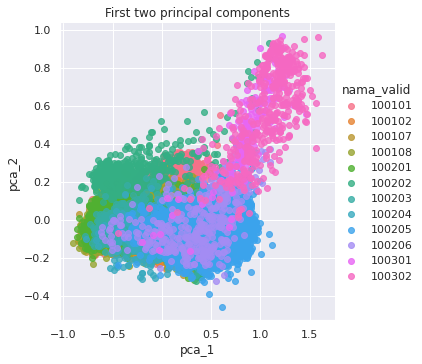

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit_transform(data_sample[standard_])
print ("Explained variances : " + str(pca.explained_variance_[0:2]))
print ("Explained variances ratio : " + str(pca.explained_variance_ratio_[0:2]))

df_Xt = pd.DataFrame(pca.fit_transform(data_sample[standard_]))
df_Xt['nama_valid'] = data_sample.nama_valid
df_Xt.rename(columns = {0:'pca_1', 1:'pca_2'}, inplace = True)

plt.figure(figsize=((24,20)))
sns.lmplot("pca_1", "pca_2", data=df_Xt, hue='nama_valid', fit_reg=False)
plt.title("First two principal components")
plt.show()

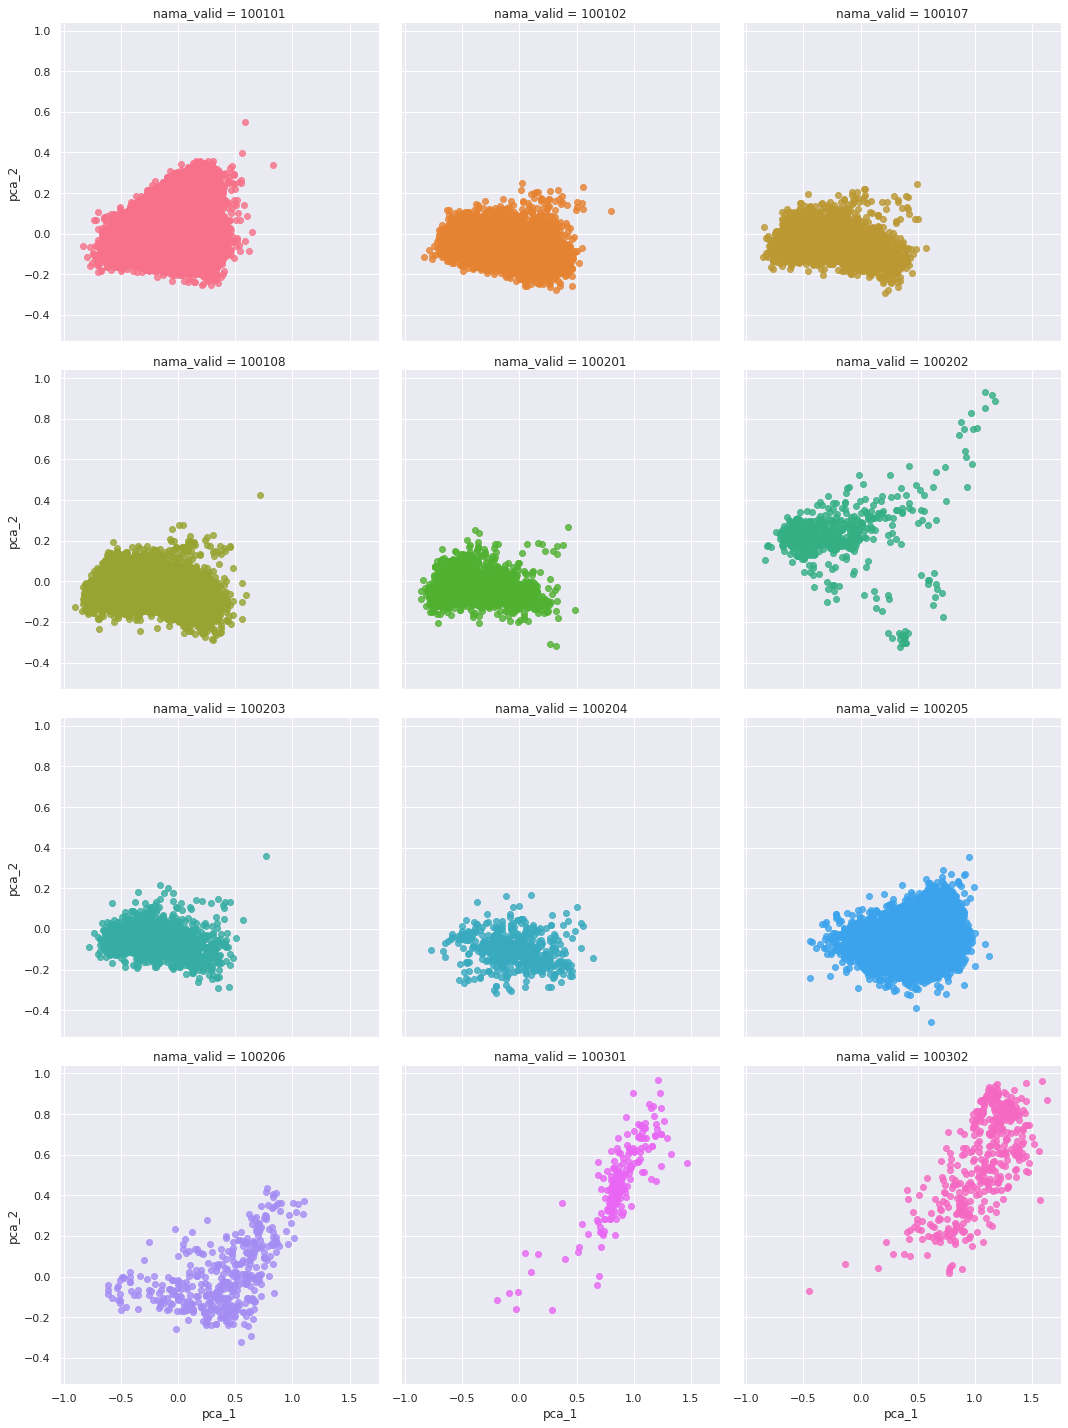

In [9]:
sns.lmplot("pca_1", "pca_2", data=df_Xt, col='nama_valid',
           hue='nama_valid', fit_reg=False, col_wrap=3)
plt.show()

In [10]:
def PCA_plot(cat1, cat2):
    global df_Xt
    sns.lmplot("pca_1", "pca_2", hue='nama_valid', data=df_Xt.query('nama_valid==@cat1 or nama_valid==@cat2'), fit_reg=False)
    plt.show()


In [11]:
interact(PCA_plot, 
         cat1=data_sample.sort_values('nama_valid').nama_valid.unique(), 
         cat2=data_sample.sort_values('nama_valid').nama_valid.unique())

interactive(children=(Dropdown(description='cat1', options=('100101', '100102', '100107', '100108', '100201', …

<function __main__.PCA_plot(cat1, cat2)>

#### [04] Exploration Data Analysis: Distribution Plot

In [12]:
def dist_plot(cat,var, save=False):
    global data_sample
    sns.distplot(data_sample.query('nama_valid==@cat')[[var]].values)
    if(save):
        plt.savefig('ml_output/02_plot/distplot_'+str(cat)+"_" + str(var)+'.png')
        plt.close()
    else:
        plt.show()


In [13]:
interact(dist_plot, cat=data_sample.sort_values('nama_valid').nama_valid.unique(), var =standard_, save=fixed(False))

interactive(children=(Dropdown(description='cat', options=('100101', '100102', '100107', '100108', '100201', '…

<function __main__.dist_plot(cat, var, save=False)>

#### [05] Exploration Data Analysis: Outlier Analysis Per Variable

In [12]:
def outlier_analysis(cat,var,save=False):
    global data_sample
    
    Q1 = data_sample.query('nama_valid==@cat')[var].quantile(0.25)
    Q3 = data_sample.query('nama_valid==@cat')[var].quantile(0.75)
    
    range_low=Q1-1.5*(Q3-Q1)
    range_up=Q3+1.5*(Q3-Q1)
    
    sns.boxplot(data=data_sample.query('nama_valid==@cat')[[var]]._to_pandas(), orient="h")
    
    
    if(save): 
        plt.savefig('plot/outlier_'+str(cat)+"_" + str(var)+'.png')
        plt.close()
    else:
        print('\nOUTLIER ANALYSIS-UNIVARIATE\n')
        print('Q1 for [',cat,':',var,'] :',Q1)
        print('Q3 for [',cat,':',var,'] :',Q3)
    
        print('IQR =',Q3-Q1)
        print('\nvalue lower than Q1-1.5*IQR: ',data_sample.query(var+'<(@range_low)').shape[0],
          '(',round(data_sample.query(var+'<(@range_low)').shape[0]/data_sample.shape[0]*100,2),'%)')
        print('value upper than Q3+1.5*IQR: ',data_sample.query(var+'>(@range_up)').shape[0],
          '(',round(data_sample.query(var+'>(@range_up)').shape[0]/data_sample.shape[0]*100,2),'%)')
        plt.figure(figsize=(3, 3))
        plt.show()
        
def box_plot(var):
    global data_sample
    sns.boxplot(y = data_sample[var].values, x = data_sample.nama_valid.values )
    plt.title("Boxplot : "+var)
    plt.show()

In [13]:
interact(outlier_analysis, cat=data_sample.sort_values('nama_valid').nama_valid.unique(), var =standard_, save=fixed(False))

interactive(children=(Dropdown(description='cat', options=('100101', '100102', '100107', '100108', '100201', '…

<function __main__.outlier_analysis(cat, var, save=False)>

In [14]:
interact(box_plot, var =standard_)

interactive(children=(Dropdown(description='var', options=('B1_p15', 'B2_p15', 'B3_p15', 'B4_p15', 'B5_p15', '…

<function __main__.box_plot(var)>

#### [06] Exploration Data Analysis: Scatter Plot

In [17]:
def scatterpl_analysis(cat,var1,var2,save=False):
    global data_sample
    data_=data_sample.query('nama_valid==@cat')._to_pandas()
    sns.scatterplot(data=data_,
               x=var1,y=var2)
    
    if(save):
        plt.savefig('plot/scatter_'+str(cat)+"_" + str(var1)+"_" + str(var2)+'.png')
        plt.close()
    else:
        print('\nSCATTER PLOT\n')
        plt.figure(figsize=(3, 3))
        plt.show()
        

In [18]:
interact(scatterpl_analysis, cat=data_sample.sort_values('nama_valid').nama_valid.unique(),
         var1 =standard_,var2=standard_, save=fixed(False))

interactive(children=(Dropdown(description='cat', options=('100101', '100102', '100107', '100108', '100201', '…

<function __main__.scatterpl_analysis(cat, var1, var2, save=False)>


#### [07] Correlation Data

In [19]:
def correlation_plot(cat, save=False):
    global data_sample
    mask = np.triu(np.ones_like(data_sample.query('nama_valid==@cat')[standard_]._to_pandas().corr().round(2), 
                            dtype=np.bool))
    # sns.heatmap(data_sample.query('nama_valid==\'100101\'')[standard_]._to_pandas().corr().round(2),
    sns.heatmap(data_sample.query('nama_valid==@cat')[standard_]._to_pandas().corr().round(2),
             mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu_r')
    if(save):
        plt.savefig('ml_output/02_plot/correlation_'+str(cat)+'.png')
        plt.close()
    else:
        print('\nCorrelation Plot\n')
        plt.figure(figsize=(3, 3))
        plt.show()
  

In [20]:
interact(correlation_plot, cat=data_sample.sort_values('nama_valid').nama_valid.unique(), save=fixed(False))

interactive(children=(Dropdown(description='cat', options=('100101', '100102', '100107', '100108', '100201', '…

<function __main__.correlation_plot(cat, save=False)>

#### [08] Outlier Analysis Multivariate

#### Mahalanobis Distance based Outlier

In [23]:
print('MAHALANOBIS DISTANCE OUTLIER----')
import scipy
data_sample['mahalo_dist']=None
for i in data_sample.nama_valid.unique():
    print('Checking for:',i)
    data=data_sample.query('nama_valid==@i')[standard_]
    x_minus_mu=data-np.mean(data)
    cov= MinCovDet().fit(data[standard_]).covariance_
    inv_covmat=scipy.linalg.pinv(cov)
    left_term=np.dot(x_minus_mu,inv_covmat)
    mahalo_dist=np.dot(left_term,x_minus_mu.T)
    data_sample.at[data.index,'mahalo_dist']=mahalo_dist.diagonal()

from scipy.stats import chi2
chi2_out=chi2.ppf((1-0.05),df=len(standard_))
print('Validating outlier with chisquare value:', chi2_out)
data_sample['flag_out_mahalanobis']=data_sample.mahalo_dist.apply(lambda y: -1 if y>chi2_out else 0)

MAHALANOBIS DISTANCE OUTLIER----
Checking for: 100101
Checking for: 100102
Checking for: 100107
Checking for: 100108
Checking for: 100201
Checking for: 100202
Checking for: 100203
Checking for: 100204
Checking for: 100205
Checking for: 100206
Checking for: 100301
Checking for: 100302
Validating outlier with chisquare value: 27.58711163827534


#### DBScan outlier

In [24]:
print('DBScan OUTLIER-----')
from sklearn.cluster import DBSCAN

data_sample['dbscan_out']=None
for i in data_sample.nama_valid.unique():
    print('Checking for:',i)
    data=data_sample.query('nama_valid==@i')[standard_]
    outlier_detection=DBSCAN(min_samples=2,eps=5)
    clusters=outlier_detection.fit_predict(data)
    data_sample.at[data.index,'dbscan_out']=clusters
data_sample['flag_out_dbscan']=data_sample.dbscan_out.apply(lambda y: -1 if y<0 else 0)

DBScan OUTLIER-----
Checking for: 100101
Checking for: 100102
Checking for: 100107
Checking for: 100108
Checking for: 100201
Checking for: 100202
Checking for: 100203
Checking for: 100204
Checking for: 100205
Checking for: 100206
Checking for: 100301
Checking for: 100302


#### Isolation Forest

In [25]:
print('Isolation forest OUTLIER-----')
from sklearn.ensemble import IsolationForest
data_sample['isofor_out']=None
for i in data_sample.nama_valid.unique():
    print('Checking for:',i)
    data=data_sample.query('nama_valid==@i')[standard_]
    clf=IsolationForest(n_estimators=300,random_state=1234,n_jobs=-1,
                       max_samples='auto',contamination='auto',
                       max_features=0.9, bootstrap=True)
    clf.fit(data)
    data_sample.at[data.index,'isofor_out']=clf.predict(data)
data_sample['flag_out_isolation']=data_sample.isofor_out.apply(lambda y: -1 if y<0 else 0)

Isolation forest OUTLIER-----
Checking for: 100101
Checking for: 100102
Checking for: 100107
Checking for: 100108
Checking for: 100201
Checking for: 100202
Checking for: 100203
Checking for: 100204
Checking for: 100205
Checking for: 100206
Checking for: 100301
Checking for: 100302


In [26]:
data_sample.head(5)

,ID_GRID,kdPIC,nama_valid,B1_p15,B2_p15,B3_p15,B4_p15,B5_p15,B6_p15,B7_p15,...,EVI_p50,GNDVI_p50,cen_x,cen_y,mahalo_dist,flag_out_mahalanobis,dbscan_out,flag_out_dbscan,isofor_out,flag_out_isolation
40633,ID-3552,F,100101,0.123700,0.094636,0.089939,0.059908,0.084963,0.135388,0.160281,...,0.293667,0.326001,116.286877,-8.787510,36.482271,-1,0,0,1,0
34794,ID-3087,F,100101,0.113775,0.087165,0.077134,0.046095,0.071875,0.148042,0.177015,...,0.465287,0.445925,114.715942,-8.376958,15.803184,0,0,0,1,0
69567,ID-3602,F,100101,0.124200,0.090467,0.083450,0.051760,0.089700,0.201733,0.248600,...,0.545542,0.454280,116.429150,-8.738555,16.561394,0,0,0,1,0
69566,ID-3602,F,100101,0.119300,0.094706,0.086550,0.057895,0.084850,0.168189,0.208526,...,0.404131,0.388314,116.460986,-8.738373,8.458882,0,0,0,1,0
69565,ID-3602,F,100101,0.124275,0.094216,0.085971,0.057893,0.089135,0.168869,0.209434,...,0.438249,0.413534,116.460806,-8.738373,7.599907,0,0,0,1,0


#### Ensembling the outlier analysis through consensus
If two of three methods (mahalanobis, dbscan, isolation forest) shows any outlier, feature would be classified as outlier.

In [27]:
data_sample['outlier_detect']=data_sample.apply(lambda y: -1 if (y.flag_out_isolation+y.flag_out_dbscan+
                                                y.flag_out_mahalanobis)<-1 else 0, axis=1)

In [30]:
data_sample_not_out=data_sample.query('outlier_detect==0')

In [31]:
data_sample.query('outlier_detect==-1').to_csv("ml_output/02_plot/sample_"+str(pic_) + "_outlier.csv")
data_sample_not_out.to_csv("gs://bps-gcp-bucket/MLST2023/preprocessing/sample_"+str(pic_) + "_no_outlier.csv",
                           index=False)
data_sample.to_csv('gs://bps-gcp-bucket/MLST2023/preprocessing/sample_'+str(pic_) + '.csv',
                   index=False)

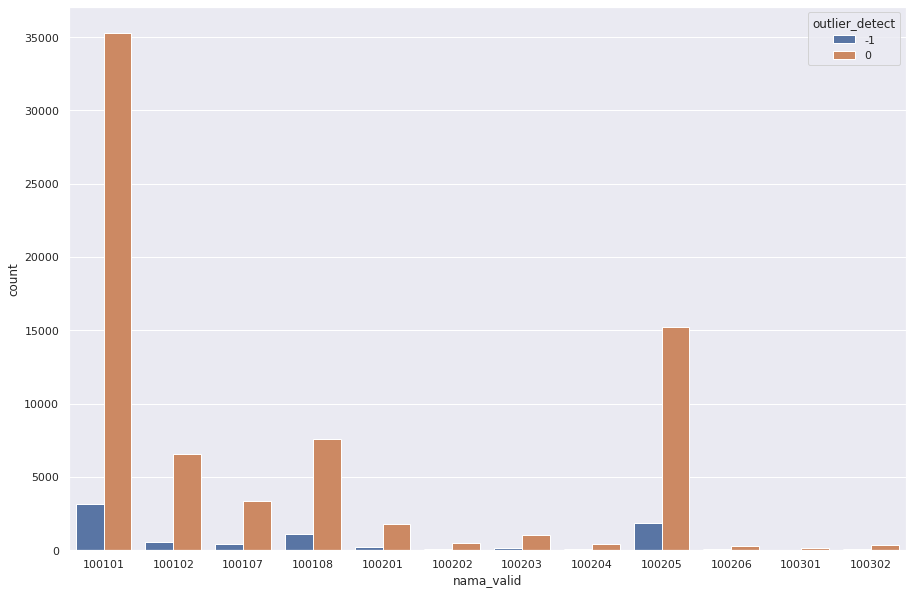

Count outlier data by category
              -1      0  % Outlier
nama_valid                        
100101      3177  35302   8.256452
100102       586   6571   8.187788
100107       426   3365  11.237141
100108      1085   7605  12.485616
100201       198   1773  10.045662
100202        93    528  14.975845
100203       141   1066  11.681856
100204        74    406  15.416667
100205      1871  15255  10.924909
100206        92    323  22.168675
100301        43    152  22.051282
100302        79    361  17.954545


In [28]:
sns.countplot(x='nama_valid',data=data_sample._to_pandas(),hue='outlier_detect')
plt.show()
print('Count outlier data by category')
table_=data_sample.pivot_table(index='nama_valid',values='ID_GRID',columns='outlier_detect',
                              aggfunc='count').rename(columns={'ID_GRID':'Count Data'})
table_['% Outlier']=table_.apply(lambda y:y[-1]*100/(y[-1]+y[0]),axis=1)
print(table_)

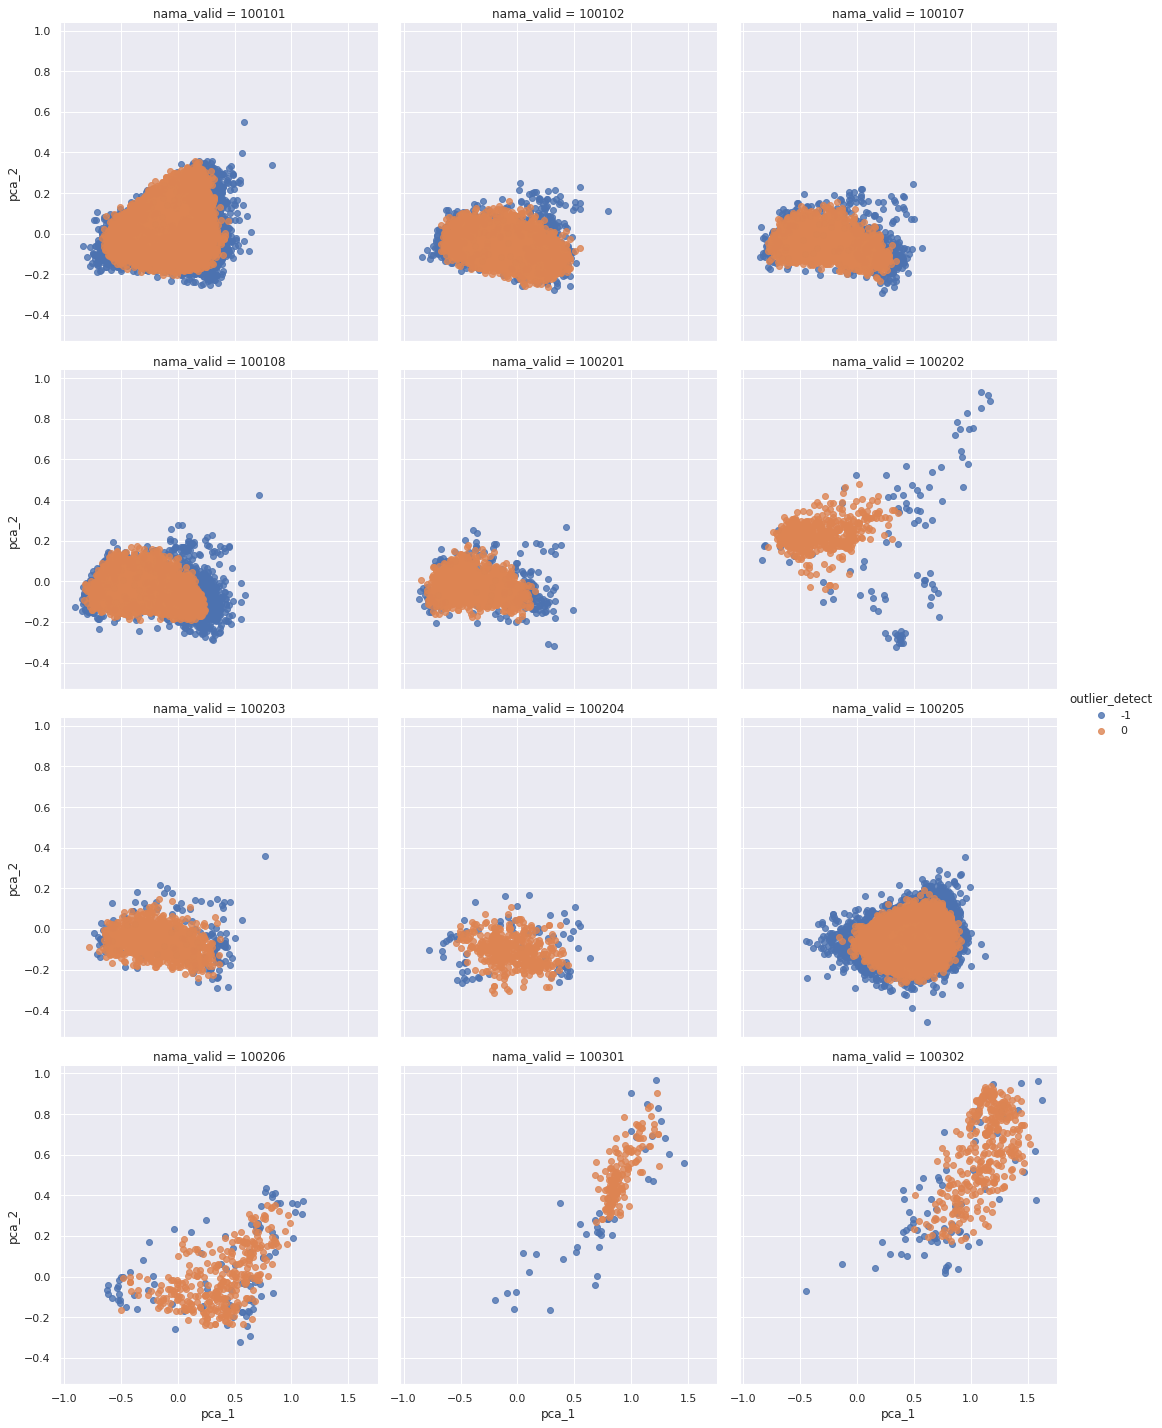

In [29]:
df_Xt['outlier_detect'] = data_sample.outlier_detect

sns.lmplot("pca_1", "pca_2", data=df_Xt, col='nama_valid',
           hue='outlier_detect', fit_reg=False, col_wrap=3)
plt.show()

#### [09]  Save All Plot

In [30]:
## Save PCA Plot

sns.lmplot("pca_1", "pca_2", data=df_Xt, hue='nama_valid', fit_reg=False)
plt.title("First-two principal components")
plt.savefig('ml_output/02_plot/pca_plot_all_category.png')
plt.close()

sns.lmplot("pca_1", "pca_2", data=df_Xt, col='nama_valid',
           hue='nama_valid', fit_reg=False, col_wrap=3)
plt.savefig('ml_output/02_plot/pca_plot_by_category.png')
plt.close()

In [31]:
## Save Count By Category

sns.countplot(x='nama_valid',data=data_sample._to_pandas(),color='blue')
plt.savefig('ml_output/02_plot/count_plot_by_category.png')
plt.close()

In [32]:
## Save Distplot

# def parallel_dist(cat):
#     global data_sample
#     for i in standard_:
#         sns.distplot(data_sample.query('nama_valid==@cat')[[i]].values)
#         plt.savefig('ml_output/02_plot/distplot_'+str(cat)+"_" + str(i)+'.png')
#         plt.close()
        
# thread_map(parallel_dist, data_sample.sort_values('nama_valid').nama_valid.unique())

In [33]:
## Save Distplot 2

plt.figure(figsize=((24,20)))
fig, axes = plt.subplots(ncols=3, nrows=6)
plt.subplots_adjust(hspace=0.7)

for i, ax in zip(range(17), axes.flat):
    sns.distplot(data_sample.loc[:,standard_[i]], ax=ax)
plt.savefig('ml_output/02_plot/displot_all_category_.png')
plt.close()

for k in list(data_sample.nama_valid.unique()):  
    plt.figure(figsize=((24,20)))
    fig, axes = plt.subplots(ncols=3, nrows=6)
    plt.subplots_adjust(hspace=0.7)

    for i, ax in zip(range(17), axes.flat):
        sns.distplot(data_sample.loc[data_sample.nama_valid==k,standard_[i]], ax=ax)
    plt.savefig('ml_output/02_plot/displot_all_bands_' + str(k)+'.png')
    plt.close()
    # break

<Figure size 1728x1440 with 0 Axes>

<Figure size 1728x1440 with 0 Axes>

<Figure size 1728x1440 with 0 Axes>

<Figure size 1728x1440 with 0 Axes>

<Figure size 1728x1440 with 0 Axes>

<Figure size 1728x1440 with 0 Axes>

<Figure size 1728x1440 with 0 Axes>

<Figure size 1728x1440 with 0 Axes>

<Figure size 1728x1440 with 0 Axes>

<Figure size 1728x1440 with 0 Axes>

<Figure size 1728x1440 with 0 Axes>

<Figure size 1728x1440 with 0 Axes>

<Figure size 1728x1440 with 0 Axes>

In [34]:
## Save Box Plot

# def parallel_outlier(cat):
#     global data_sample
#     for i in standard_:      
#         sns.boxplot(data=data_sample.query('nama_valid==@cat')[[i]]._to_pandas(), orient="h")
#         plt.savefig('ml_output/02_plot/boxplot_'+str(cat)+"_" + str(i)+'.png')
#         plt.close()

# thread_map(parallel_outlier, data_sample.sort_values('nama_valid').nama_valid.unique())

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [35]:
## Save Box Plot 2

for i in standard_:
    sns.boxplot(y=data_sample[i].values,x = data_sample.nama_valid.values)
    plt.title("Boxplot : "+i)
    plt.savefig('ml_output/02_plot/boxplot_all_category_' + str(i)+'.png')
    plt.close()
    # break

In [36]:
## Save Correlation pLot

for i in data_sample.sort_values('nama_valid').nama_valid.unique():
    correlation_plot(i, save=True)
    # break

In [37]:
## Save Result Outlier Analysis 

sns.countplot(x='nama_valid',data=data_sample._to_pandas(),hue='outlier_detect')
plt.savefig('ml_output/02_plot/count_plot_by_outlier.png') 
plt.close()

sns.lmplot("pca_1", "pca_2", data=df_Xt, col='nama_valid',
           hue='outlier_detect', fit_reg=False, col_wrap=3)
plt.savefig('ml_output/02_plot/pca_plot_by_outlier.png') 
plt.close()

In [38]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'config/gcp_store.json'
client = storage.Client()
bucket = client.get_bucket('bps-gcp-bucket')

for i in glob.glob("ml_output/02_plot/*.png"): 
    print(i)
    gcp_file_name='MLST2023/exploration/'+pic_+'/'+i[18:]
    bucket.blob(gcp_file_name).upload_from_filename(i)
    # print(tif_name + " DONE !")
print("DONE !! SELURUH PLOT TELAH TERUPLOAD !")

# for i in glob.glob("ml_output/02_plot/*.png"):
#     os.remove(i)
    

ml_output/02_plot/displot_all_bands_100203.png
ml_output/02_plot/pca_plot_by_category.png
ml_output/02_plot/boxplot_all_category_B8A_p15.png
ml_output/02_plot/correlation_100108.png
ml_output/02_plot/boxplot_all_category_B1_p15.png
ml_output/02_plot/displot_all_bands_100302.png
ml_output/02_plot/displot_all_bands_100206.png
ml_output/02_plot/correlation_100205.png
ml_output/02_plot/displot_all_category_16.png
ml_output/02_plot/boxplot_all_category_GNDVI_p50.png
ml_output/02_plot/correlation_100204.png
ml_output/02_plot/pca_plot_by_outlier.png
ml_output/02_plot/count_plot_by_outlier.png
ml_output/02_plot/correlation_100107.png
ml_output/02_plot/correlation_100302.png
ml_output/02_plot/displot_all_bands_100107.png
ml_output/02_plot/boxplot_all_category_B4_p15.png
ml_output/02_plot/displot_all_bands_100205.png
ml_output/02_plot/boxplot_all_category_NDBI_p50.png
ml_output/02_plot/boxplot_all_category_NDVI_p50.png
ml_output/02_plot/displot_all_bands_100201.png
ml_output/02_plot/boxplot_all_